📌 **Note**:
All file paths in this notebook (e.g., `/content/drive/MyDrive/...`) are from Google Colab and refer to my personal Drive.  
To run the notebook, please upload the provided datasets and model weights to your own Google Drive and update the paths accordingly.


# **License Plate Recognition using YOLOv5 and CRNN (CTC-Based OCR)**

## End-to-End Data Science Project: Automatic License Plate Recognition (ALPR)
This end-to-end project demonstrates a complete workflow  for Automatic License Plate Recognition (ALPR) from full vehicle images using deep learning.

It integrates two key components:
-  **YOLOv5**: Object detection model to accurately localize license plates in vehicle images.
-  **CRNN (Convolutional Recurrent Neural Network)**: A custom OCR model combining CNN + BiLSTM + CTC Loss to recognize license plate characters.

---

###  Key Features
*   YOLOv5 object detection model used to accurately localize license plates in full vehicle images.
- Custom OCR model built from scratch using PyTorch.
- Sequence prediction using **CTC (Connectionist Temporal Classification)** to handle variable-length plate texts.
- End-to-end inference workflow from full vehicle image to predicted plate number.
- Visualization of detection and recognition output.

---

###  Objective
To design and deploy a deep learning  workflow that detects and decodes vehicle license plates, with real-world application potential in:
- Traffic Monitoring
- Automated Toll Collection
- Smart City Surveillance

---

###  Tools & Technologies
- Python · OpenCV · PyTorch · YOLOv5 · CRNN (CNN + BiLSTM + CTC) · Matplotlib


---







----


# Preprocessing


## Step 1: Import Required Libraries

In [ ]:


import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image


%matplotlib inline


##  Step 2: Define Directory Paths


In [ ]:


BASE_DIR = "/content/drive/MyDrive/License Plate Recognition"

# Path to the data directory
DATA_DIR = os.path.join(BASE_DIR, 'data')

# Paths to detection images and label CSV
DETECTION_IMAGES_DIR = os.path.join(DATA_DIR, 'license_plates_detection_train')
DETECTION_LABELS_CSV = os.path.join(DATA_DIR, 'Licplatesdetection_train.csv')

# Paths to License plate  images and label CSV
OCR_IMAGES_DIR = os.path.join(DATA_DIR, 'license_plates_recognition_train')
OCR_LABELS_CSV = os.path.join(DATA_DIR, 'Licplatesrecognition_train.csv')

# Path to test images (for later)
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test')


## Step 3: Load and Explore Annotation Files





In [ ]:
# Load bounding box annotations for license plate detection
df_detection = pd.read_csv(DETECTION_LABELS_CSV)
print(f"Detection CSV loaded with {len(df_detection)} rows.")
display(df_detection.head())

# Load license plate text labels for OCR
df_ocr = pd.read_csv(OCR_LABELS_CSV)
print(f"OCR CSV loaded with {len(df_ocr)} rows.")
display(df_ocr.head())


Detection CSV loaded with 900 rows.


img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222

OCR CSV loaded with 900 rows.


img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979

## Step 4: Check for Missing Values




In [ ]:
print("Missing values in detection annotations:")
print(df_detection.isnull().sum())

print("\nMissing values in OCR labels:")
print(df_ocr.isnull().sum())


Missing values in detection annotations:
img_id    0
ymin      0
xmin      0
ymax      0
xmax      0
dtype: int64

Missing values in OCR labels:
img_id    0
text      0
dtype: int64


## Step 5: Visualize License Plate Detection Bounding Box


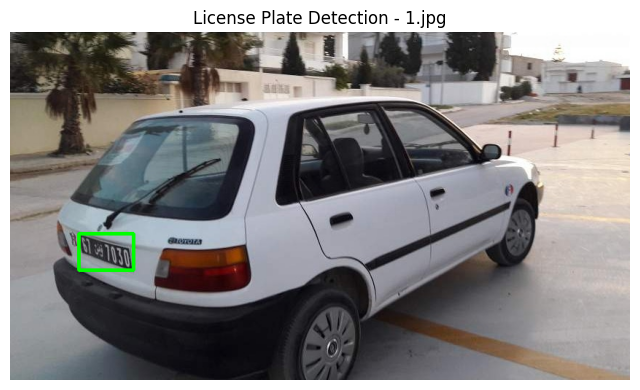

In [ ]:
def show_detection_image(img_name):
    """
    Display a vehicle image with the license plate bounding box drawn.
    """
    row = df_detection[df_detection['img_id'] == img_name]
    if row.empty:
        print(f"No bounding box found for {img_name}")
        return

    row = row.iloc[0]

    img_path = os.path.join(DETECTION_IMAGES_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image {img_name} not found in detection images folder.")
        return

    # Convert BGR (OpenCV default) to RGB for correct colors in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ymin, xmin, ymax, xmax = int(row['ymin']), int(row['xmin']), int(row['ymax']), int(row['xmax'])
    # Draw bounding box in green
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.title(f"License Plate Detection - {img_name}")
    plt.axis('off')
    plt.show()

# Show a sample detection image
show_detection_image('1.jpg')


## Step 6: Visualize Cropped License Plate and OCR Label





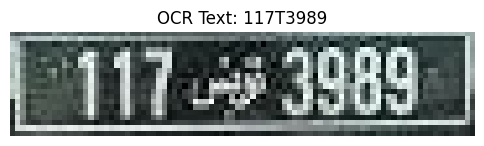

In [ ]:
def show_ocr_image(img_name):
    """
    Display a cropped license plate image with its recognized text label.
    """
    row = df_ocr[df_ocr['img_id'] == img_name]
    if row.empty:
        print(f"No OCR label found for {img_name}")
        return

    label = row.iloc[0]['text']
    img_path = os.path.join(OCR_IMAGES_DIR, img_name)

    try:
        img = Image.open(img_path)
    except FileNotFoundError:
        print(f"OCR image {img_name} not found in OCR images folder.")
        return

    plt.figure(figsize=(6,3))
    plt.imshow(img)
    plt.title(f"OCR Text: {label}")
    plt.axis('off')
    plt.show()

# Show a sample OCR image
show_ocr_image('0.jpg')


## Step 7: Analyze License Plate Text Length and Character Set




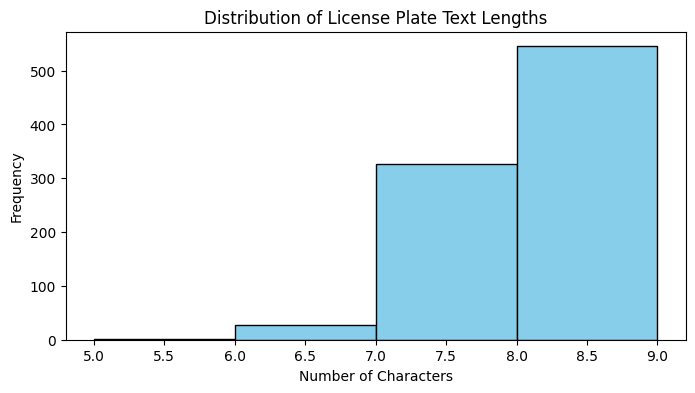

Unique characters in license plates (12): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']


In [ ]:
# Calculate length of each license plate text
df_ocr['text_length'] = df_ocr['text'].apply(len)

# Plot distribution of license plate text lengths
plt.figure(figsize=(8,4))
plt.hist(df_ocr['text_length'], bins=range(df_ocr['text_length'].min(), df_ocr['text_length'].max()+2),
         color='skyblue', edgecolor='black')
plt.title('Distribution of License Plate Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Find unique characters across all license plate texts
all_text = ''.join(df_ocr['text'].values)
unique_chars = sorted(set(all_text))
print(f"Unique characters in license plates ({len(unique_chars)}): {unique_chars}")


# Data Exploration




## Step 1: Analyze Image Dimensions (Detection Dataset)


In [ ]:
def get_image_shape(img_folder, img_list):
    heights, widths = [], []
    for img_name in img_list:
        img_path = os.path.join(img_folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            heights.append(h)
            widths.append(w)
    return heights, widths

# Apply on detection images
detection_imgs = df_detection['img_id'].tolist()
det_heights, det_widths = get_image_shape(DETECTION_IMAGES_DIR, detection_imgs)


## Step 2: Visualize Image Dimension Distribution (Detection Dataset)


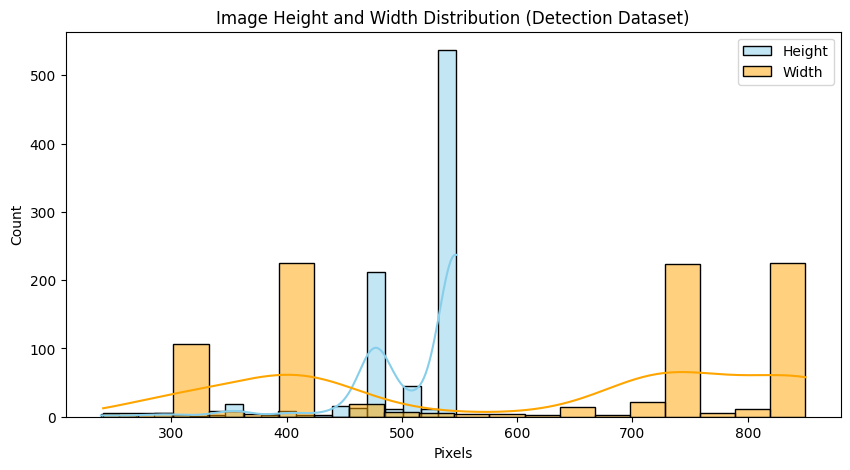

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(det_heights, bins=20, color='skyblue', label='Height', kde=True)
sns.histplot(det_widths, bins=20, color='orange', label='Width', kde=True)
plt.title("Image Height and Width Distribution (Detection Dataset)")
plt.xlabel("Pixels")
plt.legend()
plt.show()


## Step 3: Calculate Bounding Box Dimensions and Aspect Ratio

In [ ]:
df_detection['bbox_width'] = df_detection['xmax'] - df_detection['xmin']
df_detection['bbox_height'] = df_detection['ymax'] - df_detection['ymin']
df_detection['aspect_ratio'] = df_detection['bbox_width'] / df_detection['bbox_height']


## Step 4: Visualize Bounding Box Dimension Distributions

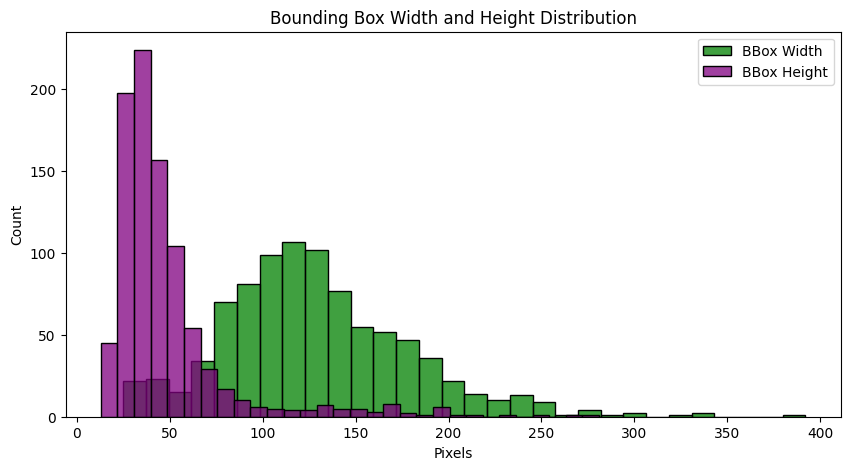

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_detection['bbox_width'], color='green', label='BBox Width', bins=30)
sns.histplot(df_detection['bbox_height'], color='purple', label='BBox Height', bins=30)
plt.title("Bounding Box Width and Height Distribution")
plt.xlabel("Pixels")
plt.legend()
plt.show()


## Step 5: Visualize Bounding Box Aspect Ratio Distribution

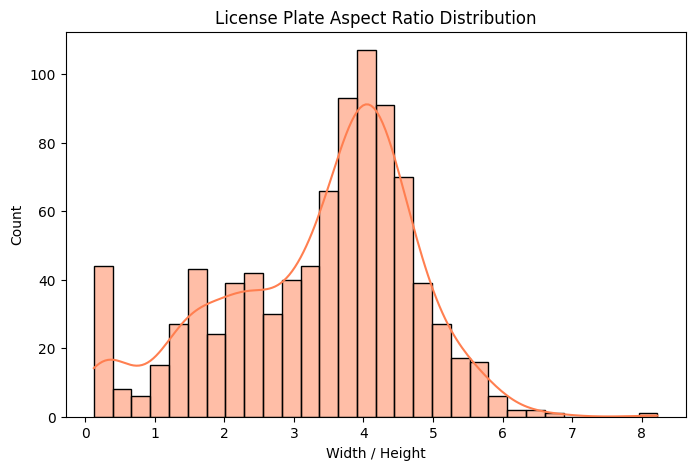

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df_detection['aspect_ratio'], bins=30, color='coral', kde=True)
plt.title("License Plate Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.show()


## Step 5: Visualize Bounding Box Aspect Ratio Distribution

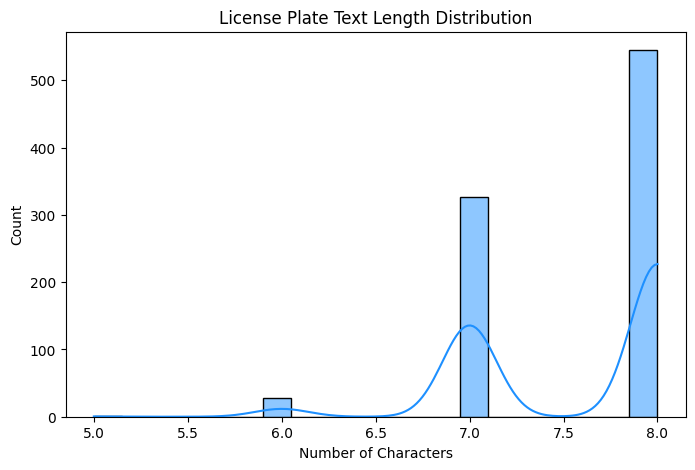

Unique characters used in plates: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
Total unique characters: 12


In [ ]:
df_ocr['text_length'] = df_ocr['text'].apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(df_ocr['text_length'], bins=20, color='dodgerblue', kde=True)
plt.title("License Plate Text Length Distribution")
plt.xlabel("Number of Characters")
plt.show()

# Unique characters
char_set = sorted(set(''.join(df_ocr['text'])))
print(f"Unique characters used in plates: {char_set}")
print(f"Total unique characters: {len(char_set)}")


# License Plate Detection using YOLOv5

This section implements license plate detection from full vehicle images using the **YOLOv5** object detection framework.

YOLOv5 (You Only Look Once) is a high-performance real-time object detection model that efficiently predicts bounding boxes around license plates.

We will:
- Load the pretrained YOLOv5 model.
- Perform inference on vehicle images.
- Visualize license plate bounding boxes.



##Step 1: Setup YOLOv5 Environment

In [ ]:
# Clone YOLOv5 repo
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17488, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 17488 (delta 0), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17488/17488), 16.54 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (11988/11988), done.
/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolov5


## Step 2: Import Required Libraries for Training YOLOv5

In [ ]:
import torch
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split


##Step 3: Prepare Dataset for YOLOv5 Training

In [ ]:
import os
from sklearn.model_selection import train_test_split


IMAGES_DIR = "/content/drive/MyDrive/License Plate Recognition/data/license_plates_detection_train"

# ✅ List all JPG images in the directory
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.jpg')]

print(f"✅ Total images found: {len(image_files)}")

# ✅ Split into 80% training and 20% validation
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

print(f"✅ Train images: {len(train_files)}")
print(f"✅ Validation images: {len(val_files)}")

# ✅ Create YOLO folder structure
yolo_base = "/content/drive/MyDrive/License Plate Recognition/YOLOv5"
os.makedirs(f"{yolo_base}/images/train", exist_ok=True)
os.makedirs(f"{yolo_base}/images/val", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_base}/labels/val", exist_ok=True)


✅ Total images found: 900
✅ Train images: 720
✅ Validation images: 180


In [ ]:
import shutil

# Function to move image files
def move_images(file_list, target_folder):
    for fname in file_list:
        src_path = os.path.join(IMAGES_DIR, fname)
        dst_path = os.path.join(target_folder, fname)
        shutil.copy(src_path, dst_path)  # You can use shutil.move if you want to move instead of copy

# ✅ Move training images
move_images(train_files, f"{yolo_base}/images/train")

# ✅ Move validation images
move_images(val_files, f"{yolo_base}/images/val")

print("✅ Images successfully copied into YOLOv5 folder structure.")


✅ Images successfully copied into YOLOv5 folder structure.


## Step 4: Convert Annotations to YOLOv5 Format

In [ ]:
import pandas as pd
import os

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/License Plate Recognition/data/Licplatesdetection_train.csv')

# Output label folders
LABELS_DIR = os.path.join(yolo_base, "labels")
os.makedirs(f"{LABELS_DIR}/train", exist_ok=True)
os.makedirs(f"{LABELS_DIR}/val", exist_ok=True)

# Image size for normalization (YOLO needs normalized coordinates)
def convert_to_yolo_format(row, img_w, img_h):
    x_center = ((row['xmin'] + row['xmax']) / 2) / img_w
    y_center = ((row['ymin'] + row['ymax']) / 2) / img_h
    width = (row['xmax'] - row['xmin']) / img_w
    height = (row['ymax'] - row['ymin']) / img_h
    return [0, x_center, y_center, width, height]  # class_id is 0

# Generate label files
for split, file_list in [('train', train_files), ('val', val_files)]:
    for fname in file_list:
        # Get annotation row
        row = df[df['img_id'] == fname]
        if row.empty:
            continue

        row = row.iloc[0]
        img_path = os.path.join(IMAGES_DIR, fname)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_h, img_w = img.shape[:2]

        yolo_vals = convert_to_yolo_format(row, img_w, img_h)
        label_path = os.path.join(LABELS_DIR, split, fname.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            f.write(' '.join([str(round(val, 6)) for val in yolo_vals]) + '\n')

print("✅ Labels converted to YOLO format and saved.")


✅ Labels converted to YOLO format and saved.


## Step 5: Create YOLOv5 Configuration File (data.yaml)

In [ ]:
import yaml

# Define paths and class names
data_yaml = {
    'train': '/content/drive/MyDrive/License Plate Recognition/YOLOv5/images/train',
    'val': '/content/drive/MyDrive/License Plate Recognition/YOLOv5/images/val',
    'nc': 1,  # Number of classes (just 'license_plate')
    'names': ['license_plate']
}

# Save to a data.yaml file
yaml_path = '/content/drive/MyDrive/License Plate Recognition/YOLOv5/data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f)

print(f"'data.yaml' created at: {yaml_path}")


'data.yaml' created at: /content/drive/MyDrive/License Plate Recognition/YOLOv5/data.yaml


## Step 6: Navigate to YOLOv5 Directory

In [ ]:
%cd /content/drive/MyDrive/License\ Plate\ Recognition/YOLOv5/yolov5


/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolov5


## Step 7: Train YOLOv5 on License Plate Detection Task

In [ ]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data /content/drive/MyDrive/License\ Plate\ Recognition/YOLOv5/data.yaml \
  --weights yolov5s.pt \
  --project /content/drive/MyDrive/License\ Plate\ Recognition/YOLOv5 \
  --name yolo_results \
  --exist-ok

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-06-09 09:46:45.721218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749462405.741285   30867 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749462405.747587   30867 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/content/drive/MyDrive/License Plate Rec

In [ ]:
# Set path to YOLOv5 repo
%cd /content/drive/MyDrive/License Plate Recognition/YOLOv5/yolov5




/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolov5


##Step 8: Run YOLOv5 Inference on Test Vehicle Images

In [ ]:
!python detect.py \
  --weights '/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolo_results/weights/best.pt' \
  --source '/content/drive/MyDrive/License Plate Recognition/data/test' \
  --imgsz 640 \
  --conf-thres 0.4 \
  --save-txt \
  --save-conf \
  --project '/content/drive/MyDrive/License Plate Recognition/YOLOv5' \
  --name inference_results \
  --exist-ok


detect: weights=['/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolo_results/weights/best.pt'], source=/content/drive/MyDrive/License Plate Recognition/data/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/License Plate Recognition/YOLOv5, name=inference_results, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to '/content/drive/MyDrive/License': No such file or directory
YOLOv5 🚀 2025-6-9 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/219 /content/drive/MyDrive/License Plate Recognition/data/test/1000.jpg: 448x640 1 li

## Step 9: Visualize YOLOv5 Detection Results

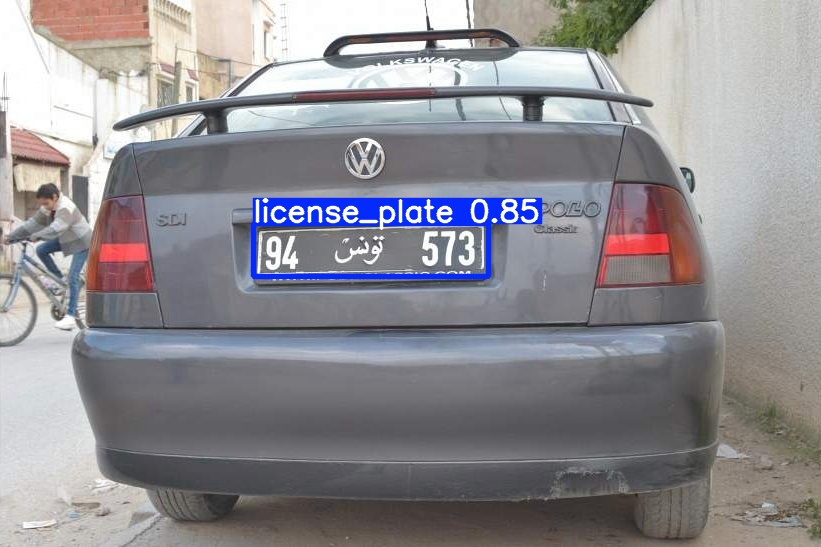

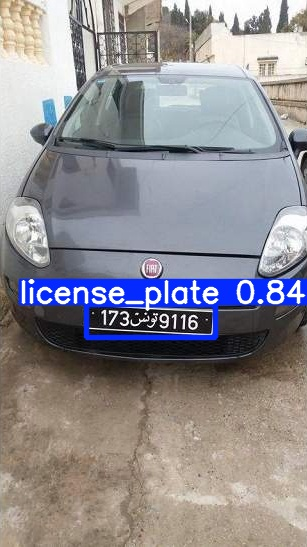

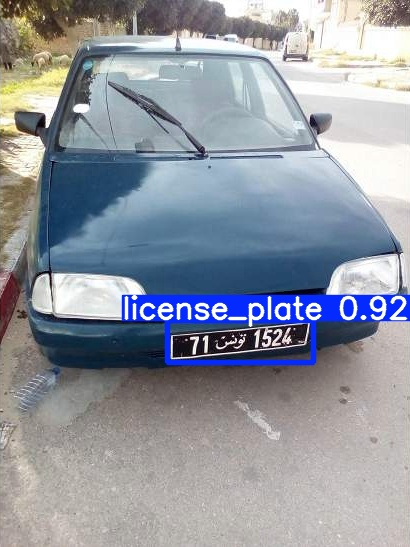

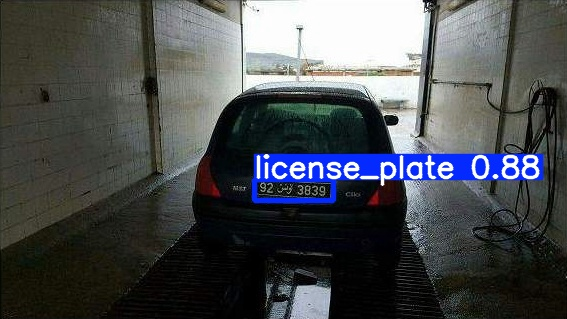

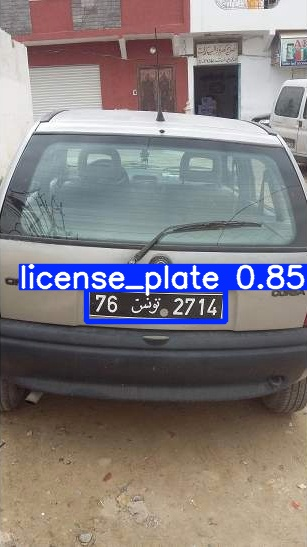

In [ ]:
from IPython.display import Image, display
import glob

# Show a few results
result_images = glob.glob('/content/drive/MyDrive/License Plate Recognition/YOLOv5/inference_results/*.jpg')[:5]
for img_path in result_images:
    display(Image(img_path))


## Step 10: Display Training Results Plot

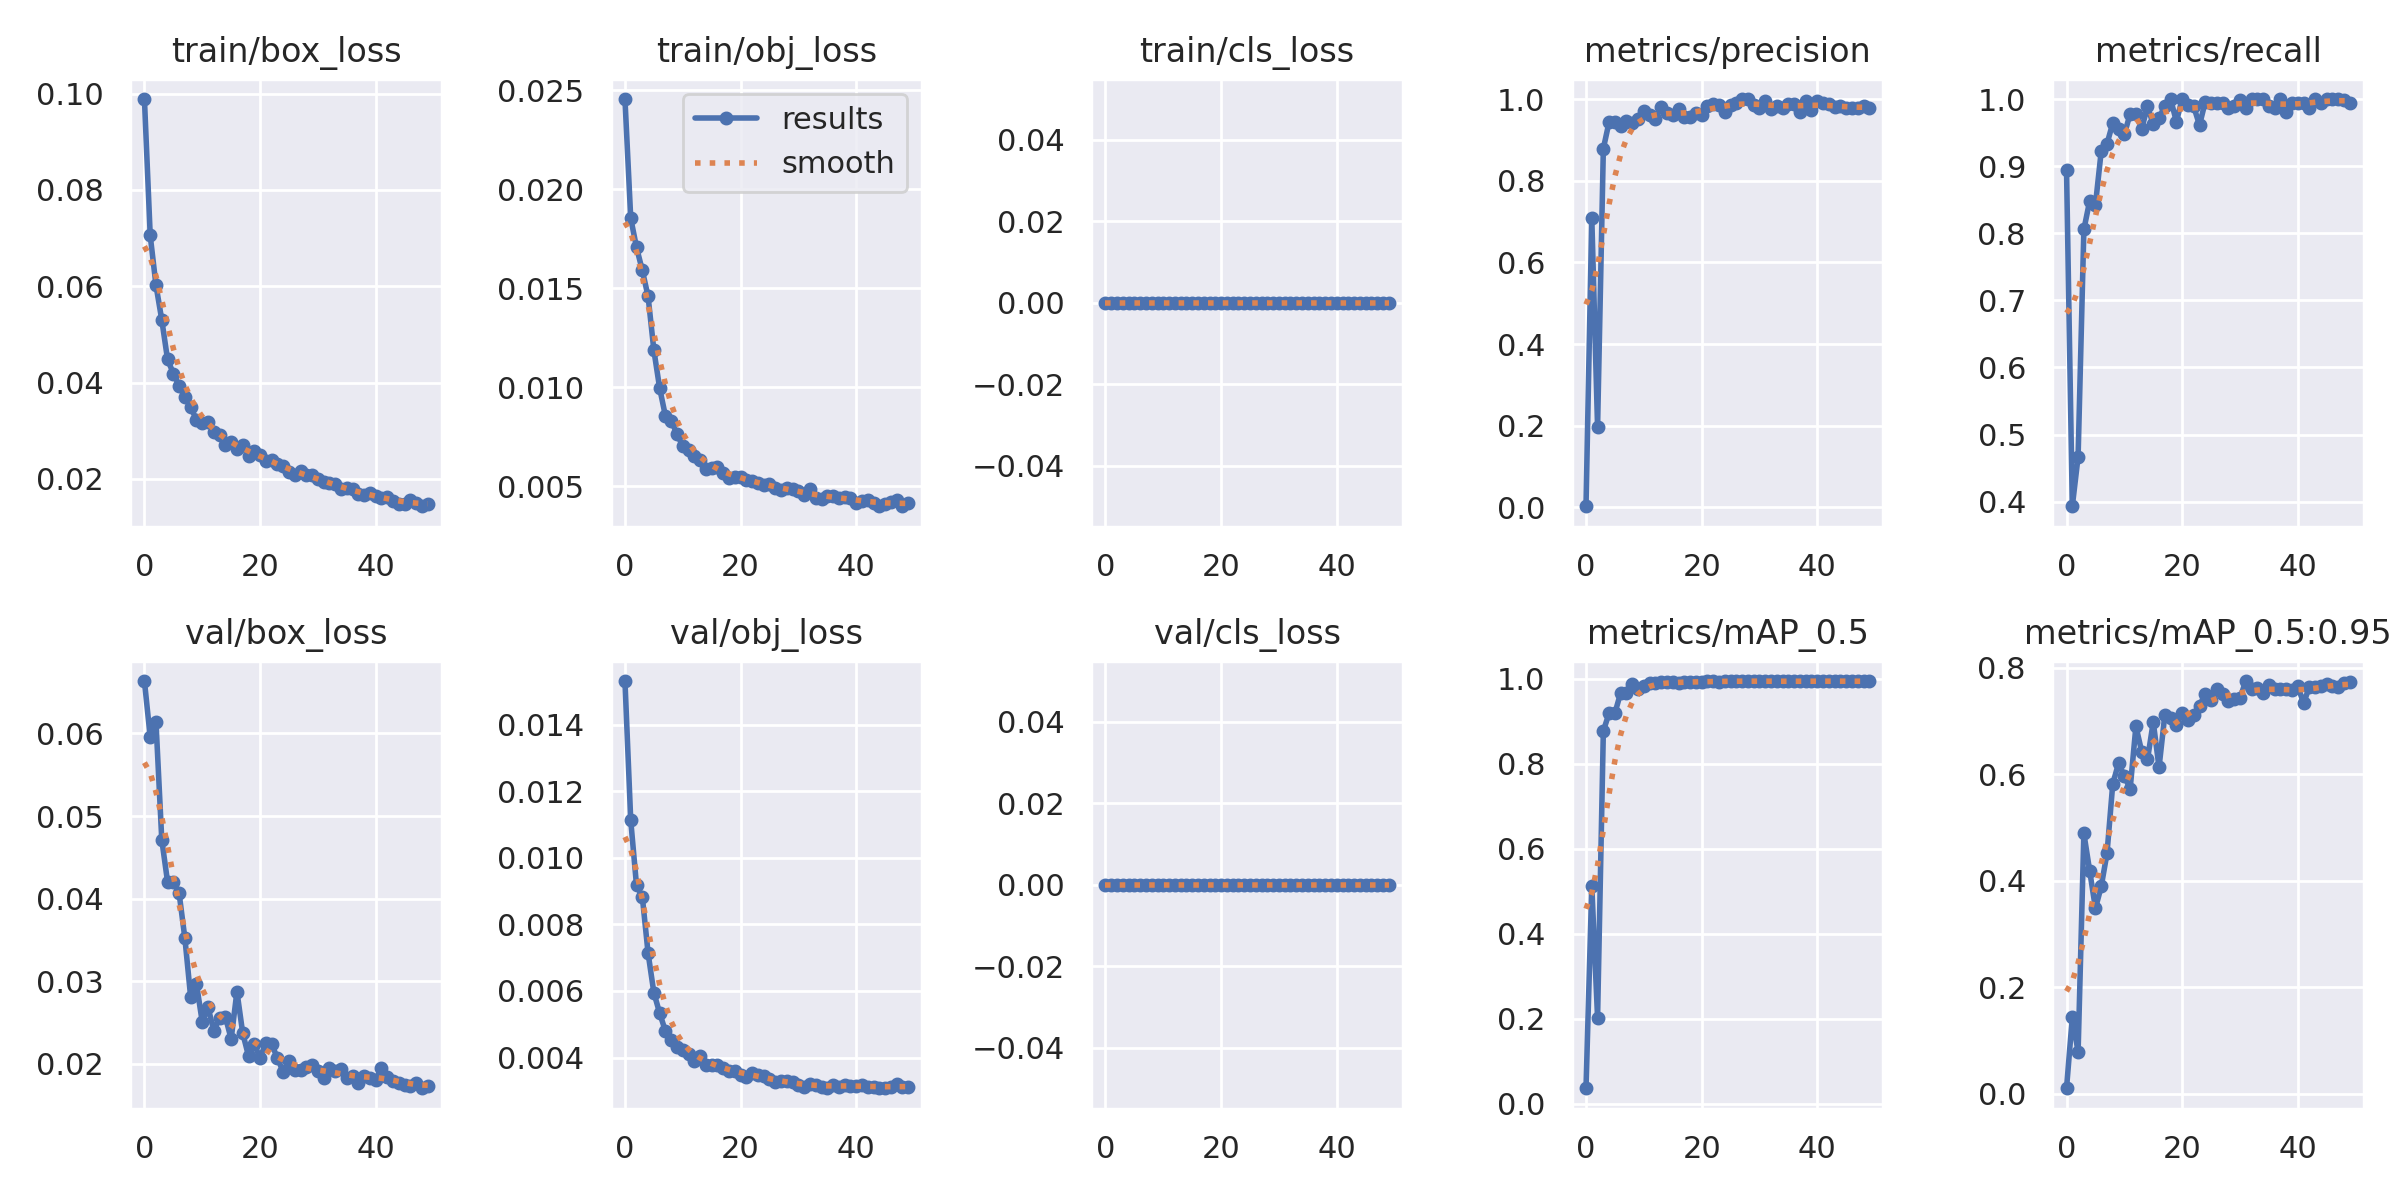

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolo_results/results.png')


## Step 11: Load and Preview YOLOv5 Training Results CSV

In [ ]:
import pandas as pd


results_path = "/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolo_results/results.csv"

df_results = pd.read_csv(results_path)
df_results.head()



epoch        train/box_loss        train/obj_loss  \
0                     0              0.098884              0.024562   
1                     1              0.070556              0.018533   
2                     2              0.060202              0.017063   
3                     3              0.053016              0.015907   
4                     4              0.044811              0.014585   

         train/cls_loss     metrics/precision        metrics/recall  \
0                     0              0.002982               0.89444   
1                     0              0.709290               0.39311   
2                     0              0.197050               0.46667   
3                     0              0.878640               0.80556   
4                     0              0.944330               0.84810   

        metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
0              0.036659              0.010711              0.066341   
1              0.511840              0.143900              0.059556   
2              0.202800              0.078961              0.061346   
3              0.877490              0.489020              0.047125   
4              0.919730              0.419260              0.042033   

           val/obj_loss          val/cls_loss                 x/lr0  \
0              0.015306                     0              0.070667   
1              0.011120                     0              0.040536   
2              0.009168                     0              0.010274   
3              0.008833                     0              0.009406   
4              0.007137                     0              0.009406   

                  x/lr1                 x/lr2  
0              0.003259              0.003259  
1              0.006462              0.006462  
2              0.009533              0.009533  
3              0.009406              0.009406  
4              0.009406              0.009406

## Step 12: Clean and Extract Final YOLOv5 Model Evaluation Metrics

In [ ]:
# ✅ Remove extra spaces in column names
df_results.columns = df_results.columns.str.strip()

# ✅ Now safely extract the final row's key metrics
final_metrics = df_results.tail(1)[[
    'metrics/precision',
    'metrics/recall',
    'metrics/mAP_0.5',
    'metrics/mAP_0.5:0.95'
]]

print("📊 Final Evaluation Metrics:")
print(final_metrics)

📊 Final Evaluation Metrics:
    metrics/precision  metrics/recall  metrics/mAP_0.5  metrics/mAP_0.5:0.95
49             0.9792         0.99444          0.99456               0.77312


## Step 13: Visualize YOLOv5 Model Evaluation Metrics Over Training Epochs

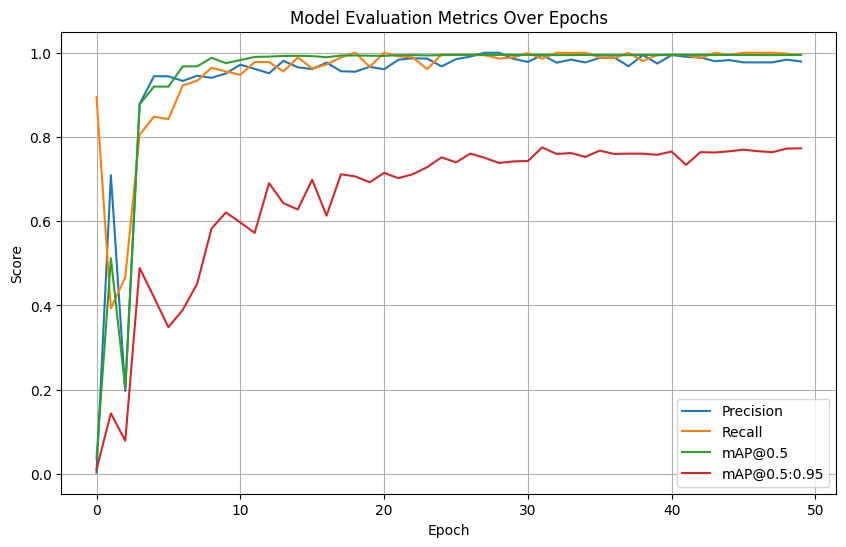

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_results['epoch'], df_results['metrics/precision'], label='Precision')
plt.plot(df_results['epoch'], df_results['metrics/recall'], label='Recall')
plt.plot(df_results['epoch'], df_results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(df_results['epoch'], df_results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# 🖋️ License Plate Recognition using CRNN (CTC-Based OCR)

This section implements license plate character recognition using a custom **CRNN** (Convolutional Recurrent Neural Network) model combined with **CTC Loss** for sequence prediction.

The CRNN model combines CNN layers for spatial feature extraction, BiLSTM layers for sequence modeling, and CTC (Connectionist Temporal Classification) loss to handle variable-length license plate texts without explicit character-level alignment.

We will:
- Build the CRNN architecture from scratch using PyTorch.
- Prepare cropped license plate images and corresponding text labels.
- Train the model to recognize license plate characters.
- Evaluate and visualize recognition results on test images.


##Step 1: Preprocessing

###Load OCR Dataset CSV

In [ ]:
import pandas as pd

# Load CSV
df = pd.read_csv('/content/drive/MyDrive/License Plate Recognition/data/Licplatesrecognition_train.csv')

# Preview
print(df.head())
print("✅ Total samples:", len(df))


    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979
✅ Total samples: 900


###Extract Unique Characters from License Plate Texts

In [ ]:
char_set = set("".join(df['text'].values))
print("✅ Unique characters in labels:", sorted(char_set))
print("🔢 Total unique characters:", len(char_set))


✅ Unique characters in labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
🔢 Total unique characters: 12


###Analyze License Plate Text Lengths

count    900.000000
mean       7.572222
std        0.560376
min        5.000000
25%        7.000000
50%        8.000000
75%        8.000000
max        8.000000
Name: length, dtype: float64


<Axes: >

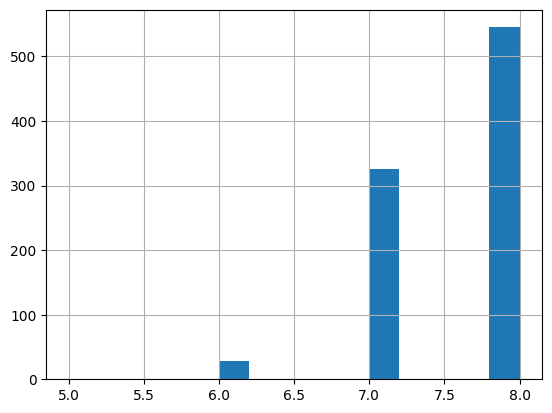

In [ ]:
df['length'] = df['text'].apply(len)
print(df['length'].describe())
df['length'].hist(bins=15)


###Check Dimensions of Sample OCR Images

In [ ]:
import cv2
import os
import pandas as pd

img_path = "/content/drive/MyDrive/License Plate Recognition/data/license_plates_recognition_train"
heights, widths = [], []

for fname in df['img_id'].head(50):  # Use 'img_id' here
    full_path = os.path.join(img_path, fname)
    if os.path.exists(full_path):
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            h, w = img.shape
            heights.append(h)
            widths.append(w)
        else:
            print(f"⚠️ Image load failed for: {fname}")
    else:
        print(f"❌ File not found: {fname}")

# Show median height and width
if heights and widths:
    print("✅ Median Height:", pd.Series(heights).median())
    print("✅ Median Width:", pd.Series(widths).median())
else:
    print("❌ No valid images found.")


✅ Median Height: 36.0
✅ Median Width: 128.5


###Visualize Sample OCR Images

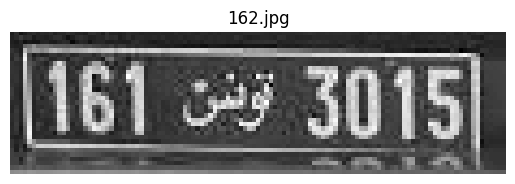

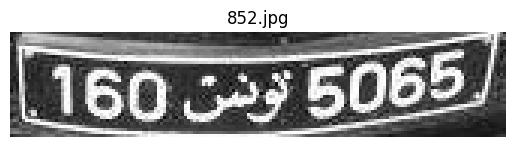

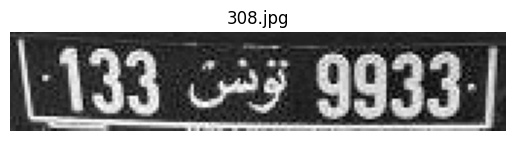

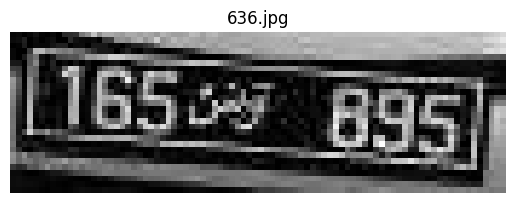

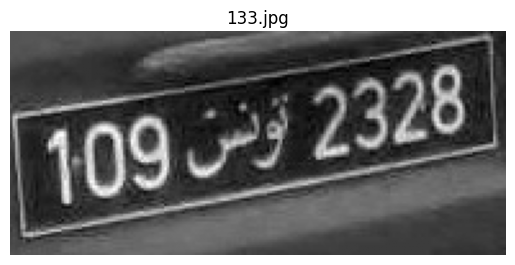

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

sample_imgs = df['img_id'].sample(5, random_state=42).values
img_path = "/content/drive/MyDrive/License Plate Recognition/data/license_plates_recognition_train"

for fname in sample_imgs:
    full_path = os.path.join(img_path, fname)
    if os.path.exists(full_path):
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            plt.imshow(img, cmap='gray')
            plt.title(fname)
            plt.axis('off')
            plt.show()
        else:
            print(f"⚠️ Failed to load: {fname}")
    else:
        print(f"❌ File not found: {fname}")


## Step 2: Import Required Libraries

In [ ]:

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


##Step 3: Define Character Set and Constants

In [ ]:

CHAR_LIST = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
CHAR2IDX = {c: i + 1 for i, c in enumerate(CHAR_LIST)}  # 0 is reserved for CTC blank
IDX2CHAR = {i + 1: c for i, c in enumerate(CHAR_LIST)}
NUM_CLASSES = len(CHAR_LIST) + 1  # for CTC blank

MAX_LABEL_LEN = 10
IMG_H, IMG_W = 36, 128

##Step 4: Create OCR Dataset and Collate Function

In [ ]:

class OCRDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['img_id'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_W, IMG_H))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=0)

        label = [CHAR2IDX[c] for c in row['text']]
        return torch.FloatTensor(img), torch.LongTensor(label), row['text']

def ocr_collate_fn(batch):
    images, labels, texts = zip(*batch)
    images = torch.stack(images)

    label_lengths = torch.IntTensor([len(label) for label in labels])
    labels_concat = torch.cat(labels)
    input_lengths = torch.full(size=(images.size(0),), fill_value=IMG_W // 4, dtype=torch.int)

    return {
        'images': images,
        'labels': labels_concat,
        'input_lengths': input_lengths,
        'label_lengths': label_lengths,
        'texts': texts
    }

##Step 5: Define the OCR Model (CNN + BiLSTM + CTC)

In [ ]:

class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 18x64
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 9x32
        )
        self.lstm = nn.LSTM(input_size=128 * 9, hidden_size=128, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(128 * 2, NUM_CLASSES)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x.log_softmax(2)

##Step 6: Define Greedy Decoder to Convert Model Outputs to Text

In [ ]:


def greedy_decoder(preds):
    pred_indices = preds.argmax(2).detach().cpu().numpy()
    pred_texts = []
    for pred in pred_indices:
        prev = -1
        decoded = ''
        for p in pred:
            if p != prev and p != 0:
                decoded += IDX2CHAR.get(p, '')
            prev = p
        pred_texts.append(decoded)
    return pred_texts


##Step 7: Define Accuracy Calculation Function

In [ ]:
def compute_accuracy(preds, truths):
    total_chars, correct_chars, exact_matches = 0, 0, 0
    for pred, true in zip(preds, truths):
        total_chars += len(true)
        correct_chars += sum(p == t for p, t in zip(pred, true))
        if pred == true:
            exact_matches += 1
    return correct_chars / total_chars, exact_matches / len(truths)

##Step 8: Prepare DataLoaders, Model, Optimizer, and Loss

In [1]:

df = pd.read_csv('/content/drive/MyDrive/License Plate Recognition/data/Licplatesrecognition_train.csv')
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_ds = OCRDataset(train_df, '/content/drive/MyDrive/License Plate Recognition/data/license_plates_recognition_train')
val_ds = OCRDataset(val_df, '/content/drive/MyDrive/License Plate Recognition/data/license_plates_recognition_train')

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=ocr_collate_fn)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=ocr_collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)






##Step 9: Train the OCR Model with CTC Loss

In [2]:

NUM_EPOCHS = 50
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0
    for batch in train_dl:
        images = batch['images'].to(device)
        labels = batch['labels'].to(device)
        input_lengths = batch['input_lengths']
        label_lengths = batch['label_lengths']

        optimizer.zero_grad()
        output = model(images)
        loss = ctc_loss(output.permute(1, 0, 2), labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📘 Epoch {epoch} - Train Loss: {total_loss / len(train_dl):.4f}")


📘 Epoch 1 - Train Loss: 2.8634
📘 Epoch 2 - Train Loss: 2.4984
📘 Epoch 3 - Train Loss: 2.4369
📘 Epoch 4 - Train Loss: 2.3965
📘 Epoch 5 - Train Loss: 2.3628
📘 Epoch 6 - Train Loss: 2.3435
📘 Epoch 7 - Train Loss: 2.3310
📘 Epoch 8 - Train Loss: 2.2557
📘 Epoch 9 - Train Loss: 2.2214
📘 Epoch 10 - Train Loss: 2.1598
📘 Epoch 11 - Train Loss: 2.1051
📘 Epoch 12 - Train Loss: 2.0219
📘 Epoch 13 - Train Loss: 1.8571
📘 Epoch 14 - Train Loss: 1.6207
📘 Epoch 15 - Train Loss: 1.3338
📘 Epoch 16 - Train Loss: 1.0298
📘 Epoch 17 - Train Loss: 0.7499
📘 Epoch 18 - Train Loss: 0.5260
📘 Epoch 19 - Train Loss: 0.3823
📘 Epoch 20 - Train Loss: 0.3085
📘 Epoch 21 - Train Loss: 0.2192
📘 Epoch 22 - Train Loss: 0.1526
📘 Epoch 23 - Train Loss: 0.1189
📘 Epoch 24 - Train Loss: 0.0914
📘 Epoch 25 - Train Loss: 0.0750
📘 Epoch 26 - Train Loss: 0.0627
📘 Epoch 27 - Train Loss: 0.0429
📘 Epoch 28 - Train Loss: 0.0322
📘 Epoch 29 - Train Loss: 0.0306
📘 Epoch 30 - Train Loss: 0.0655
📘 Epoch 31 - Train Loss: 0.0829
📘 Epoch 32 - Trai

##Step 10: Evaluate the OCR Model on Validation Set

In [3]:

model.eval()
all_preds, all_texts = [], []
with torch.no_grad():
    for batch in val_dl:
        images = batch['images'].to(device)
        texts = batch['texts']
        output = model(images)
        decoded = greedy_decoder(output)
        all_preds.extend(decoded)
        all_texts.extend(texts)

char_acc, exact_acc = compute_accuracy(all_preds, all_texts)

print("\n📊 Final Evaluation Metrics:")
print(f"✅ Character-Level Accuracy: {char_acc:.4f}")
print(f"✅ Exact String Match Accuracy: {exact_acc:.4f}")

# Show sample predictions
print("\n🔎 Sample Predictions vs Ground Truth:")
for true, pred in list(zip(all_texts, all_preds))[:10]:
    print(f"True : {true} | Pred : {pred}")


📊 Final Evaluation Metrics:
✅ Character-Level Accuracy: 0.9429
✅ Exact String Match Accuracy: 0.8444

🔎 Sample Predictions vs Ground Truth:
True : 161T3015 | Pred : 161T3015
True : 160T5065 | Pred : 160T5065
True : 133T9933 | Pred : 133T9933
True : 165T895 | Pred : 165T695
True : 109T2328 | Pred : 109T2328
True : 161T3747 | Pred : 161T3747
True : 160T2955 | Pred : 160T2955
True : 78T3293 | Pred : 78T3293
True : 123T3112 | Pred : 123T3112
True : 142T7100 | Pred : 145T7100


In [4]:
# Assume all_texts (true labels) and all_preds (predicted texts) are available and same length

# 1. Exact Match Count
exact_matches = sum([true == pred for true, pred in zip(all_texts, all_preds)])
total_samples = len(all_texts)
exact_match_accuracy = exact_matches / total_samples

# 2. Character-Level Accuracy
def char_level_accuracy(true_texts, pred_texts):
    total_chars = 0
    correct_chars = 0
    for true, pred in zip(true_texts, pred_texts):
        total_chars += len(true)
        correct_chars += sum(t == p for t, p in zip(true, pred))
    return correct_chars / total_chars if total_chars else 0

char_accuracy = char_level_accuracy(all_texts, all_preds)

# 3. Print Results
print("📊 Final Evaluation Metrics:")
print(f"✅ Exact String Matches: {exact_matches} / {total_samples}")
print(f"🎯 Exact Match Accuracy: {exact_match_accuracy:.4f}")
print(f"✅ Character-Level Accuracy: {char_accuracy:.4f}")

# 4. 🔍 Sample Predictions
print("\n🔎 Sample Predictions vs Ground Truth:")
for true, pred in list(zip(all_texts, all_preds))[:10]:
    print(f"True : {true} | Pred : {pred}")


📊 Final Evaluation Metrics:
✅ Exact String Matches: 76 / 90
🎯 Exact Match Accuracy: 0.8444
✅ Character-Level Accuracy: 0.9429

🔎 Sample Predictions vs Ground Truth:
True : 161T3015 | Pred : 161T3015
True : 160T5065 | Pred : 160T5065
True : 133T9933 | Pred : 133T9933
True : 165T895 | Pred : 165T695
True : 109T2328 | Pred : 109T2328
True : 161T3747 | Pred : 161T3747
True : 160T2955 | Pred : 160T2955
True : 78T3293 | Pred : 78T3293
True : 123T3112 | Pred : 123T3112
True : 142T7100 | Pred : 145T7100


## Step 11: Save Trained CRNN Model

In [5]:

torch.save(model.state_dict(), '/content/drive/MyDrive/License Plate Recognition/crnn_license_plate_ocr3.pth')
print("✅ Model saved!")

✅ Model saved!


#  Inference: License Plate Recognition Using YOLOv5 + CRNN

This script performs license plate recognition by combining:

- **YOLOv5**: For detecting and cropping license plate regions from full vehicle images.
- **CRNN (CNN + BiLSTM + CTC)**: For reading the alphanumeric text from the cropped plate image.

It loads both trained models, processes test images, predicts license plate texts, and saves results with visualization.


In [19]:

# Import Libraries

import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import warnings

# Suppress FutureWarnings from autocast
warnings.filterwarnings("ignore", category=FutureWarning)

#  Define CRNN model

CHAR_LIST = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'N', 'T']
IDX2CHAR = {i + 1: c for i, c in enumerate(CHAR_LIST)}

class OCRModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, padding=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
            torch.nn.Conv2d(64, 128, 3, padding=1), torch.nn.BatchNorm2d(128), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2),
        )
        self.lstm = torch.nn.LSTM(128 * 9, 128, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = torch.nn.Linear(256, len(CHAR_LIST) + 1)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x.log_softmax(2)

#  Greedy Decoder for CRNN model Predictions

def greedy_decoder(preds):
    pred_indices = preds.argmax(2).detach().cpu().numpy()
    pred_texts = []
    for pred in pred_indices:
        prev = -1
        decoded = ''
        for p in pred:
            if p != prev and p != 0:
                decoded += IDX2CHAR.get(p, '')
            prev = p
        pred_texts.append(decoded)
    return pred_texts

#  Load Pretrained Models (YOLOv5 for Detection + CRNN for OCR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load YOLOv5 model (fine-tuned for license plates)
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/License Plate Recognition/YOLOv5/yolo_results/weights/best.pt')
yolo_model.conf = 0.4
yolo_model.iou = 0.4

#  Load CRNN  model weights
ocr_model = OCRModel().to(device)
ocr_model.load_state_dict(torch.load("/content/drive/MyDrive/License Plate Recognition/crnn_license_plate_ocr3.pth", map_location=device))
ocr_model.eval()


# Define Inference Helper Function for OCR
def predict_plate_text(cropped_img):
    img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 36))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=(0, 1))
    img_tensor = torch.FloatTensor(img).to(device)

    with torch.no_grad():
        preds = ocr_model(img_tensor)
        text = greedy_decoder(preds)[0]
    return text

#Run Inference on Test Images Folder
test_img_dir = "/content/drive/MyDrive/License Plate Recognition/data/test"
output_csv_path = "/content/drive/MyDrive/License Plate Recognition/test_predictions_new.csv"
output_vis_dir = "/content/drive/MyDrive/License Plate Recognition/test_predictions_vis"
os.makedirs(output_vis_dir, exist_ok=True)

results = []
for img_name in os.listdir(test_img_dir):
    if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue

    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    results_yolo = yolo_model(img)

    preds = results_yolo.pred[0]
    if preds is not None and len(preds) > 0:
        x1, y1, x2, y2 = map(int, preds[0][:4])
        cropped = img[y1:y2, x1:x2]
        pred_text = predict_plate_text(cropped)

        # Save CSV result
        results.append({'img_id': img_name, 'predicted_text': pred_text})

        # Visualize
        vis_img = img.copy()
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(vis_img, pred_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
        cv2.imwrite(os.path.join(output_vis_dir, img_name), vis_img)

        # Also show the image inline (remove if running a long batch)
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.title(f"{img_name} → {pred_text}")
        plt.axis("off")
        plt.show()
    else:
        results.append({'img_id': img_name, 'predicted_text': 'No Detection'})
        print(f"⚠️ No plate detected in {img_name}")

# Save Final Results to CSV
pd.DataFrame(results).to_csv(output_csv_path, index=False)
print(f"\n✅ Predictions saved to: {output_csv_path}")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-6-11 Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 



✅ Predictions saved to: /content/drive/MyDrive/License Plate Recognition/test_predictions_new.csv


###Visualize First 10 Vehicle Images with Detected License Plates and Predicted Text

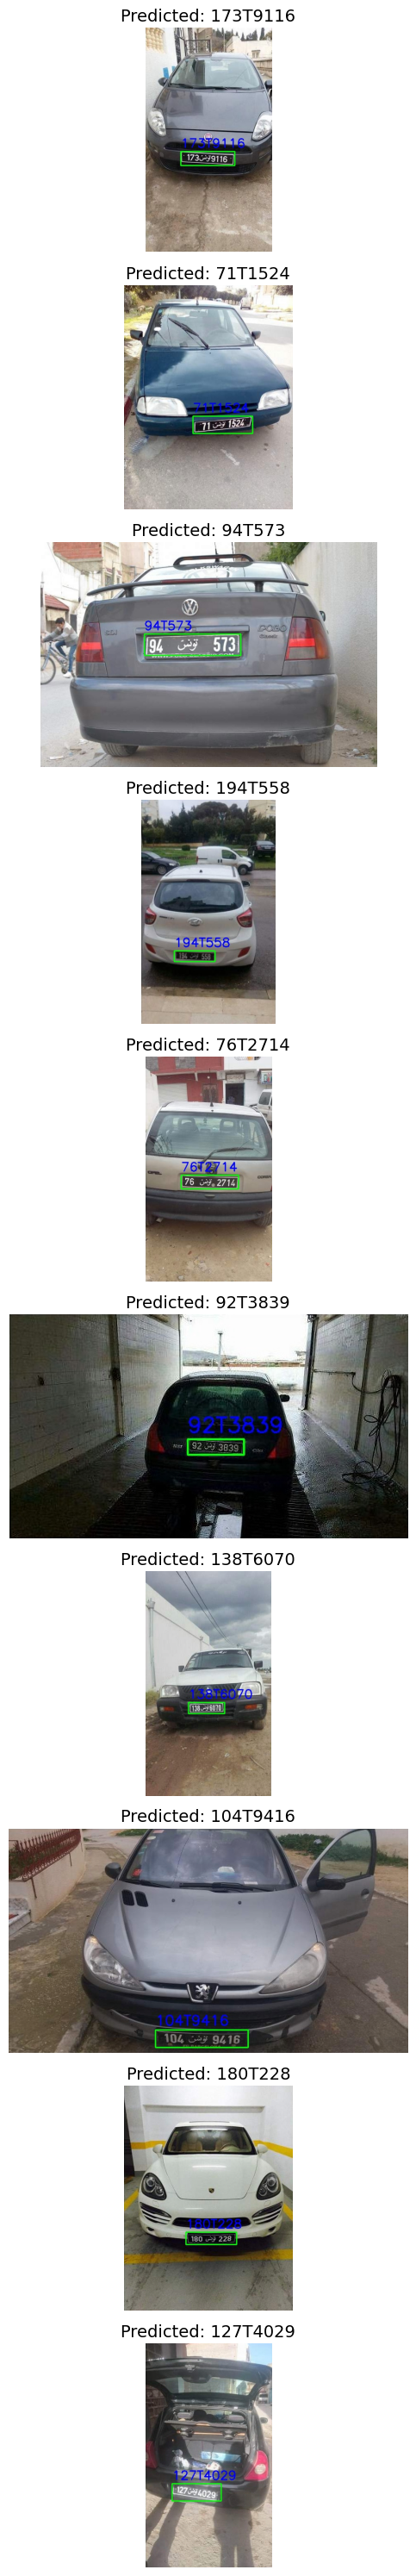

In [9]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Make sure matplotlib is set to inline (for notebooks)
%matplotlib inline

# Path to your prediction CSV and image folder
csv_path = "/content/drive/MyDrive/License Plate Recognition/test_predictions_new.csv"
image_dir = "/content/drive/MyDrive/License Plate Recognition/test_predictions_vis/"

# Read predictions CSV
df = pd.read_csv(csv_path)

# Visualize only first 10
# Show 10 images: 5 rows × 2 columns
plt.figure(figsize=(15, 30))  # Taller canvas

for i in range(10):
    row = df.iloc[i]
    img_path = os.path.join(image_dir, row['img_id'])

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Couldn't load image: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(10, 1, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {row['predicted_text']}", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

##  Final Summary

This notebook demonstrates a complete pipeline for automatic license plate recognition (ALPR), integrating YOLOv5 for license plate detection and a CRNN-based OCR model for character recognition.

- Successfully processed and predicted license plate texts on test vehicle images.
- Visualized predictions with bounding boxes and decoded plate numbers.
- The modular structure allows easy retraining or testing with new datasets.

📌 Note: All paths used here are from Google Colab Drive. Please update paths if running locally or in a different environment.
